In [1]:
import fitz

In [16]:
import re

In [76]:
import language_tool_python

In [77]:
tool = language_tool_python.LanguageTool('de-DE')

Unzipping C:\Users\julia\AppData\Local\Temp\tmpptgmq4nz.zip to C:\Users\julia\.cache\language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to C:\Users\julia\.cache\language_tool_python.


In [126]:
file = ...

In [127]:
doc = fitz.open(file)

In [134]:
max_lines_footnotes = 10
startpage = 6
endpage = 26
pages = range(startpage, endpage+1)
box = doc[0].cropbox
box[1] = box[3] * (1 / 12)
box[3] *= 0.9
all_texts = []
for nr, page in enumerate(doc, start=1):
    if nr not in pages:
        continue
    lines = page.get_textbox(box).splitlines(keepends=True)
    lines_striped = [line.strip() for line in lines]
    index_empty_end = lines_striped[::-1].index("")
    if 0 < index_empty_end <= max_lines_footnotes and any(re.match(r"^\d+( )*(vgl|siehe)", line[:10].lower()) for line in lines_striped[-max_lines_footnotes:]):
        lines = lines[:len(lines)-index_empty_end]
    all_texts.append("".join(lines))

In [135]:
replace_pattern = {
    r"-( )\n[^ ]": "- ",
    r"(\w)-\n(\w)": r"\1\2",
    r"(\s){2,}": " ",
    r"([^\d]\.)\d+ ([A-Z0-9])": r"\1 \2"
}

In [136]:
text = "".join(all_texts)
for old, new in replace_pattern.items():
    text = re.sub(old, new, text)

In [139]:
text

'1 Die Vertretungsformen nach BGB und HGB Das Bürgerliche Gesetzbuch (kurz BGB) scheint vom Namen her erstmal nicht für unternehmerisch Tätige bestimmt zu sein, aber das ist ein Irrtum. Das BGB enthält Regelungen für jedermann und es regelt beispielsweise, wie ein Vertrag zustande kommt und welche Verpflichtungen sich aus einem Kaufvertrag ergeben. Zudem enthalten viele Vorschriften Sonderregelungen für den Fall, dass dem Verbraucher ein Geschäftstreibender als Partner gegenübersteht. Die Stellvertretung ist ebenfalls im BGB geregelt. Das BGB gilt somit gleichermaßen für Privatperson, wie auch für den Kaufmann und für Gewerbetreibende. Doch für einige Fälle sind die Regelungen im BGB nicht präzise genug. Das HGB regelt diese speziellen Fälle, aber es ist nicht auf Grundlage des BGB entstanden, sondern auf den Vorgänger des HGB, dem Allgemeine Deutsche Handelsgesetzbuch (kurz ADHGB). Die Vorrausetzungen und die Rechtsfolgen der Stellvertretung sind allgemein in §§ 164 ff. BGB geregelt. 

In [78]:
matches = tool.check(text)

In [128]:
typos = set(match.matchedText for match in matches if match.category == "TYPOS")

In [129]:
typos.remove("nd")

In [130]:
other = {}
for match in matches:
    if match.category == "TYPOS" or match.ruleId == "DE_CASE":
        continue
    if match.category == "STYLE":
        text = match.context
        shorten = int(len(text)/3)
        text = text[shorten:-shorten]
    else:
        text = match.matchedText
    desc = match.message
    if text in other:
        other[text].append(desc)
    else:
        other[text] = [desc]
other

{'Praxisbeispiel': ['Bitte prüfen Sie, ob hier der Plural benutzt werden muss.'],
 'der Geschäftsführen': ['Möglicherweise fehlende grammatische Übereinstimmung des Genus (männlich, weiblich, sächlich - Beispiel: ‚der Fahrrad‘ statt ‚das Fahrrad‘).'],
 'wegen dem Umfang': ['Die Präposition ‚wegen‘ erfordert standardsprachlich den Genitiv.'],
 'am vertreten. Die Vorgehensweis': ['Drei aufeinanderfolgende Sätze beginnen mit dem gleichen Wort. Evtl. können Sie den Satz umformulieren, zum Beispiel, indem Sie ein Synonym nutzen.'],
 'Kraft': ['In diesem Kontext ist „kraft“ eine Präposition und sollte kleingeschrieben werden.'],
 'eine Prokura. Die Person mit Pr': ['Drei aufeinanderfolgende Sätze beginnen mit dem gleichen Wort. Evtl. können Sie den Satz umformulieren, zum Beispiel, indem Sie ein Synonym nutzen.'],
 'Rechtsgeschäft bei dem': ['Sollten Sie hier ein Komma einfügen?'],
 'Facility Management': ['Dieses Wort wird mit Bindestrich geschrieben.',
  'Dieses Wort wird mit Bindestrich g

In [131]:
for page in doc:
    for text, desc in other.items():
        highlight = page.search_for(text)
        for match in highlight:
            highlight = page.add_highlight_annot(match)
            highlight.set_info(content="\n".join(desc), title="J. Götting")
            highlight.set_colors(stroke=(0, 0.6, 1))
            highlight.update()
    for typo in typos:
        highlight = page.search_for(typo)
        for match in highlight:
            highlight = page.add_squiggly_annot(match)
            highlight.set_colors(stroke=(0, 0.6, 1))
            highlight.update()

In [132]:
if doc.can_save_incrementally():
    doc.save(doc.name, incremental=True, encryption=fitz.PDF_ENCRYPT_KEEP)
else:
    doc.save(doc.name.replace(".pdf", "_highlighted.pdf"))

In [140]:
doc.close()

In [ ]:
tool.close()

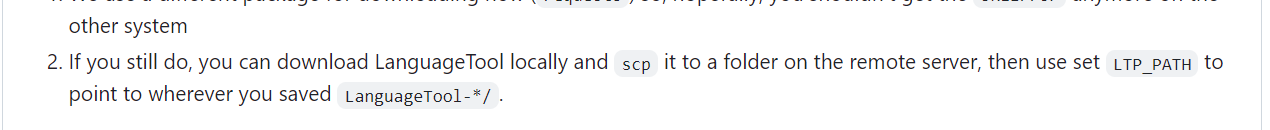